# What to expect

In notebooks 2A and 2B we took a first look at the results from STAR, loading them as a DeseqDataSet and normalizing them with DeSeq2. In this session we are going to look at which genes are the most highly differentially expressed, and investigate the GO terms and pathways associated with them. We will do this first for the example dataset <i>Schistosoma mansoni</i>, and then in notebook 3B you will repeat the process for your chosen dataset.

In [1]:
#Install PyDESeq2 and import required classes
! pip install --quiet pydeseq2

In [2]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet

# load in the counts and metadata again
counts = pd.read_csv("analysis/Schistosoma_mansoni/star/ReadsPerGene.csv", index_col=0).T
metadata = pd.read_csv("data/Schistosoma_mansoni/metadata.csv", index_col=0)

# restrict to the 2 stages we want to compare
counts_s = counts[metadata["stage"].isin(["cercarium","24 hr schistosomulum"])]
metadata_s = metadata[metadata["stage"].isin(["cercarium","24 hr schistosomulum"])]

# create deseq2 dataset object
dds = DeseqDataSet(
    counts=counts_s,
    metadata=metadata_s,
    design_factors="stage",  # compare samples based on the developmental "stage"
    refit_cooks=True
)

# Differential Expression analysis

As we did in notebook 2A, we will apply the `deseq2` method to our dds object. Remember that this method normalises the data, estimates the dispersion and calculates the log fold change (LFC) based on the design factor.

In [3]:
# Run DeSeq2
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.97 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 1.19 seconds.

Fitting LFCs...
... done in 0.74 seconds.

Replacing 0 outlier genes.



This time, however, we also want to perform a statistical analysis, to find out which differences in gene expression are statistically significant. To do that, we use the class `DeseqStats` on our dds object, and store the output in a new object called "stat_res" 

In [4]:
from pydeseq2.ds import DeseqStats

stat_res=DeseqStats(dds)

Now, we have to generate a summary of the statistical analysis contained in the "stat_res" object. To do that, we use the `summary` method.

In [5]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: stage cercarium vs 24 hr schistosomulum
                      baseMean  log2FoldChange     lfcSE      stat  \
gene                                                                 
gene:Smp_000020    4894.181166        0.220494  0.167259  1.318274   
gene:Smp_000030   18780.967017        0.640823  0.113384  5.651821   
gene:Smp_000040    5663.668190       -0.609066  0.135706 -4.488135   
gene:Smp_000050    2824.491025       -1.787652  0.281828 -6.343063   
gene:Smp_000070    1794.569198        0.465374  0.162851  2.857666   
...                        ...             ...       ...       ...   
gene:Smp_900070   41334.608763        2.999898  0.434496  6.904325   
gene:Smp_900080    6394.476687        3.246539  0.357579  9.079215   
gene:Smp_900090  159155.732267        4.304425  0.436314  9.865439   
gene:Smp_900100    5753.668599        1.824721  0.937269  1.946848   
gene:Smp_900110  114952.325564        3.702547  0.455816  8.122895   

           

... done in 0.47 seconds.



Voila! This is the raw result of our differential expression analysis. We can find out more about the columns in these results on the [page for the DeSeq2 gene-level differential expression workflow](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html), as the python module we are using is a wrapper for the original tool written in R. Let's take a moment to make sure we understand it. 

<div class="alert alert-block alert-warning">

Questions:
    
1. baseMean: what is this value? How is it calculated?
    
2. log2FoldChange: why do you think the fold change is calculated as log2? 
    For gene Smp318880, the log2FoldChange is 4.93. Is this gene more expressed in cercarium or in 24 hr schistosomulum? How many times more?
    
3. lfcSE: what is this value?
    
4. stat: what is this value?
    
5. pvalue and padj: what is the difference between these two values?

<div class="alert alert-block alert-success">

Answers:

1. `baseMean` is "the average of the normalized count values, divided by the size factors, taken over all samples in the DESeqDataSet" [see section 5.2 Building the results table](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#building-the-results-table)
2. A log2 transformation makes the fold change biologically meaningful - a `log2FoldChange` +1 means that the gene expression has doubled, whilst a `log2FoldChange` of -1 means that the gene expression has halved.
   One other motivation for transforming using a logarithm is that the variance of measured gene expression is often dependant on the level of gene expression. By log-transforming, you reduce this dependence and your data becomes better-behaved for statistical testing.
   The first line of print out in the `.summary()` says that the test is "stage cercarium vs 24 hr schistosomulum" so a log2FoldChange of 4.93 is more expressed in cercarium, and the expression level is approximately 2^4.93=30.5x higher.
4. `lfcSE` is the the standard error estimate for the log2 fold change estimate
5. `stat` is the Wald statistic of this test
6. The null hypothesis for DE analysis is that there is no change in gene expression between the 2 groups. The p value for each gene is the probability of getting these gene expression counts under the null hypothesis, and a low p value <0.05 is considered significant because it is unlikely to happen under the null hypothesis. However we have to account for multiple testing - even under the null hypothesis you would expect to see more extreme differences in expression levels some of the time! DESeq2 uses the Benjamini-Hochberg (BH) adjustment to correct for the number of tests [see section 5.4 Multiple testing](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#multiple-testing)

We will now store the results in a dataframe, so we can explore the results further. It is also a good idea to save the dataframe as a csv file, in case we want to use outside Noteable.

In [6]:
# use ".results_df" to store results in a dataframe called "res"
res = stat_res.results_df

# save to csv file
res.to_csv(f"analysis/Schistosoma_mansoni/cercarum_vs_24h_schistosomulum.full.csv")

You probably saw in the stat_res summary that some genes have very low expression, indicated by a low baseMean. The results for a gene that is very lowly expressed will probably not be very reliable, or very informative of a biological function. They might also make further visualisation skewed. To avoid this, we will filter results to remove genes with very low expression. A common (although arbitrary) threshold for this is a baseMean of 10. 

<div class="alert alert-block alert-warning">

Task:

6. Filter out results with baseMean<10

In [7]:
# Filter results with baseMean<10 so that gene expressions close to zero don't skew results
res=res[res.baseMean>=10]
res

baseMean  log2FoldChange     lfcSE      stat  \
gene                                                                 
gene:Smp_000020    4894.181166        0.220494  0.167259  1.318274   
gene:Smp_000030   18780.967017        0.640823  0.113384  5.651821   
gene:Smp_000040    5663.668190       -0.609066  0.135706 -4.488135   
gene:Smp_000050    2824.491025       -1.787652  0.281828 -6.343063   
gene:Smp_000070    1794.569198        0.465374  0.162851  2.857666   
...                        ...             ...       ...       ...   
gene:Smp_900070   41334.608763        2.999898  0.434496  6.904325   
gene:Smp_900080    6394.476687        3.246539  0.357579  9.079215   
gene:Smp_900090  159155.732267        4.304425  0.436314  9.865439   
gene:Smp_900100    5753.668599        1.824721  0.937269  1.946848   
gene:Smp_900110  114952.325564        3.702547  0.455816  8.122895   

                       pvalue          padj  
gene                                         
gene:Smp_000020  1.874118e-01  2.438906e-01  
gene:Smp_000030  1.587573e-08  4.829457e-08  
gene:Smp_000040  7.184938e-06  1.710631e-05  
gene:Smp_000050  2.252418e-10  7.986301e-10  
gene:Smp_000070  4.267691e-03  7.386299e-03  
...                       ...           ...  
gene:Smp_900070  5.044280e-12  2.021945e-11  
gene:Smp_900080  1.093606e-19  7.234159e-19  
gene:Smp_900090  5.877677e-23  4.686442e-22  
gene:Smp_900100  5.155293e-02  7.571242e-02  
gene:Smp_900110  4.551929e-16  2.395313e-15  

[8555 rows x 6 columns]

Lets start exploring the results. 

<div class="alert alert-block alert-warning">

Questions: 

7. How many genes are significantly differentially expressed?
8. For how many of these significant genes is the fold change (FC) greater than 2 or less than 0.5? Store them in a new dataframe called "sigs", and save it as a csv file

<div class="alert alert-block alert-success">

Answers: 

7. 6194
8. 3820

In [8]:
# Count the number of genes with padj<0.05
sum(res.padj<0.05)

6192

In [9]:
# Get list of only genes that have a fold change FC > 2 or FC < 0.5 and are significantly changed
sigs=res[(res.padj<0.05)&(abs(res.log2FoldChange)>1)]
sigs

baseMean  log2FoldChange     lfcSE       stat  \
gene                                                                  
gene:Smp_000050    2824.491025       -1.787652  0.281828  -6.343063   
gene:Smp_000080      12.055362       -1.996874  0.907744  -2.199820   
gene:Smp_000100   26042.364286        2.741560  0.086648  31.640281   
gene:Smp_000150    5933.919227        1.861954  0.238958   7.791970   
gene:Smp_000160     821.898894       -3.572022  0.229271 -15.579944   
...                        ...             ...       ...        ...   
gene:Smp_900060   16889.104818        2.434262  0.781077   3.116543   
gene:Smp_900070   41334.608763        2.999898  0.434496   6.904325   
gene:Smp_900080    6394.476687        3.246539  0.357579   9.079215   
gene:Smp_900090  159155.732267        4.304425  0.436314   9.865439   
gene:Smp_900110  114952.325564        3.702547  0.455816   8.122895   

                        pvalue           padj  
gene                                           
gene:Smp_000050   2.252418e-10   7.986301e-10  
gene:Smp_000080   2.781966e-02   4.272928e-02  
gene:Smp_000100  1.031707e-219  9.854863e-217  
gene:Smp_000150   6.597227e-15   3.226662e-14  
gene:Smp_000160   9.964134e-55   3.339558e-53  
...                        ...            ...  
gene:Smp_900060   1.829848e-03   3.337542e-03  
gene:Smp_900070   5.044280e-12   2.021945e-11  
gene:Smp_900080   1.093606e-19   7.234159e-19  
gene:Smp_900090   5.877677e-23   4.686442e-22  
gene:Smp_900110   4.551929e-16   2.395313e-15  

[3820 rows x 6 columns]

In [10]:
# save it as a csv file
sigs.to_csv(f"analysis/Schistosoma_mansoni/cercarum_vs_24h_schistosomulum.filtered.csv")

# Visualisation - Volcano Plot

<figure>
    <img src="https://scienceparkstudygroup.github.io/rna-seq-lesson/img/volcano_plot.png" align="right" width="400">
</figure>

Another common way to visualise differential expression analysis results is a volcano plot.
The advantage of this plot is that we can see at the same time the change in gene expression and the statistical significance of that change, for each gene. That makes it easy to identify genes for further analysis.
As shown in the figure on the right (taken from [this source](https://scienceparkstudygroup.github.io/rna-seq-lesson/06-differential-analysis/index.html#3-volcano-plot)), in a typical volcano plot:
* on the X axys we plot the log2 fold change in gene expression
* on the Y axys we plot the -log10Pvalue. Why? Because:

    (a) The p-value is transformed into Log10 to help with visualisation, in the same way that the fold change in gene expression was calculated as log2 by PyDeseq2. 

    (b) If you remember previous stats lessons, P values are a probability, and therefore are always between 0 and 1. The log10 of a number between 0 and 1 will always be negative. To make interpretation easier, we do "-"log10, so the result is always a positive number. For example: log10(0.5)=-0.301 ; -[log10(0.5)]=-[-0.301]=0.301.

Let's plot our results in a volcano plot. To do that, we will use matplotlib, which we importas "plt", and which you already used in the Data Exploration last year. If you need a quick refresher, have a look [here](https://matplotlib.org/stable/users/explain/quick_start.html)

<div class="alert alert-block alert-warning">
    
9. Using matplotlib, make a scatter plot that: 
* in the X axys plots the log2FoldChange values from the "res" dataframe 
* in the Y axys plots -log10 of the padj values from the "res" dataframe

<details>
<summary><i>Hint</i></summary>

- `apply` a lambda function to transform the padj to log10 using a numpy
- you can have a look at the Data Exploration in Biology class 3 (week 2), where lambda functions were introduced
    
</details>

/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/2747128135.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)), s=1)


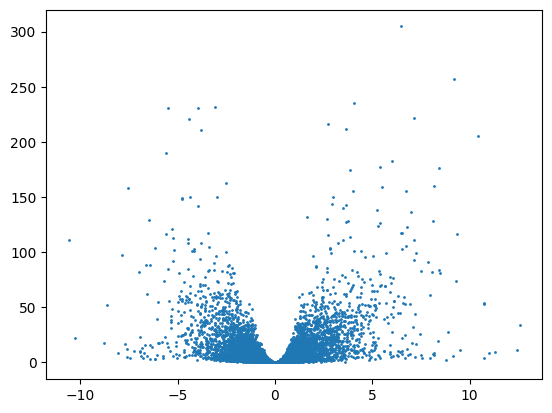

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)), s=1)

Let's make the volcano plot fancier by coloring dots depending on:
* whether they are up- or down- regulated
* whether they are significantly regulated

/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/2897689294.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/2897689294.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")


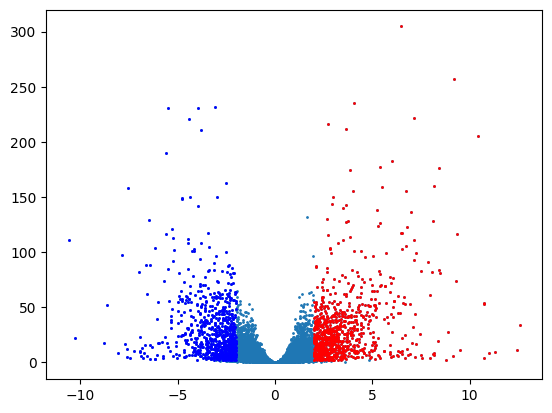

In [13]:
# define which parameters determine if a gene is significantly up or down
down = res[(res['log2FoldChange']<=-2)&(res['padj']<0.01)]
up = res[(res['log2FoldChange']>=2)&(res['padj']<0.01)]

# plot the all the genes and then highlight downregulated and upregulated
plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=1,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")

Let's improve the volcano plot further by adding:
* lines at the threshold values
* axys labels

And let's save it as a png image

/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/1719965785.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/1719965785.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")


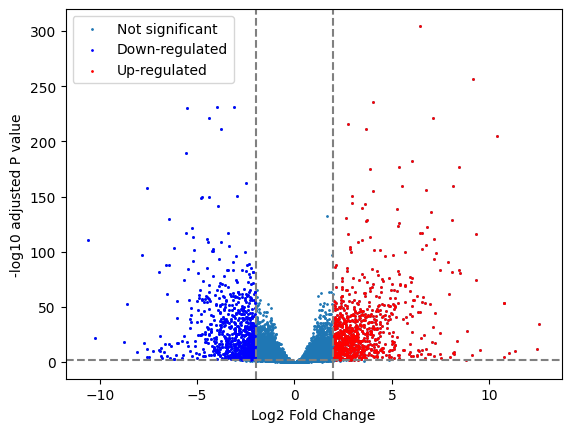

In [14]:
# define which parameters determine if a gene is significantly up or down
down = res[(res['log2FoldChange']<=-2)&(res['padj']<0.01)]
up = res[(res['log2FoldChange']>=2)&(res['padj']<0.01)]

# plot the all the genes and then highlight downregulated and upregulated
plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=1,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")

#Add axys labels
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10 adjusted P value")

# Add threshold lines
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

plt.savefig('example_volcano.png')

# Visualisation - Interactive Volcano Plot (Extension)

To explore our data, it would be very convenient if we coud hover over a dot and get the gene name. Making that sort of interactive plot is possible using the python library [plotly](https://plotly.com/python/).

In [15]:
# First, we install and import
! pip install plotly
! pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

  Using cached chart_studio-1.1.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
Using cached chart_studio-1.1.0-py3-none-any.whl (64 kB)
Using cached retrying-1.3.4-py3-none-any.whl (11 kB)


In [16]:
# Plotly requires a slightly different input than matplotlib. In our dataframe res, we need to:
# - create a new column with the gene names
# - create a new column with the transformed -log10(padj)
res['gene']=res.index
res['-log10 p value']=-np.log(res['padj'])

/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/1978341577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['gene']=res.index
/opt/miniconda3/envs/pathbio3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_83002/1978341577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['-log10 p value']=-np.log(res['padj'])

In [17]:
# lets check that it worked
res

baseMean  log2FoldChange     lfcSE      stat  \
gene                                                                 
gene:Smp_000020    4894.181166        0.220494  0.167259  1.318274   
gene:Smp_000030   18780.967017        0.640823  0.113384  5.651821   
gene:Smp_000040    5663.668190       -0.609066  0.135706 -4.488135   
gene:Smp_000050    2824.491025       -1.787652  0.281828 -6.343063   
gene:Smp_000070    1794.569198        0.465374  0.162851  2.857666   
...                        ...             ...       ...       ...   
gene:Smp_900070   41334.608763        2.999898  0.434496  6.904325   
gene:Smp_900080    6394.476687        3.246539  0.357579  9.079215   
gene:Smp_900090  159155.732267        4.304425  0.436314  9.865439   
gene:Smp_900100    5753.668599        1.824721  0.937269  1.946848   
gene:Smp_900110  114952.325564        3.702547  0.455816  8.122895   

                       pvalue          padj             gene  -log10 p value  
gene                                                                          
gene:Smp_000020  1.874118e-01  2.438906e-01  gene:Smp_000020        1.411035  
gene:Smp_000030  1.587573e-08  4.829457e-08  gene:Smp_000030       16.845947  
gene:Smp_000040  7.184938e-06  1.710631e-05  gene:Smp_000040       10.976063  
gene:Smp_000050  2.252418e-10  7.986301e-10  gene:Smp_000050       20.948123  
gene:Smp_000070  4.267691e-03  7.386299e-03  gene:Smp_000070        4.908129  
...                       ...           ...              ...             ...  
gene:Smp_900070  5.044280e-12  2.021945e-11  gene:Smp_900070       24.624376  
gene:Smp_900080  1.093606e-19  7.234159e-19  gene:Smp_900080       41.770303  
gene:Smp_900090  5.877677e-23  4.686442e-22  gene:Smp_900090       49.112198  
gene:Smp_900100  5.155293e-02  7.571242e-02  gene:Smp_900100        2.580813  
gene:Smp_900110  4.551929e-16  2.395313e-15  gene:Smp_900110       33.665262  

[8555 rows x 8 columns]

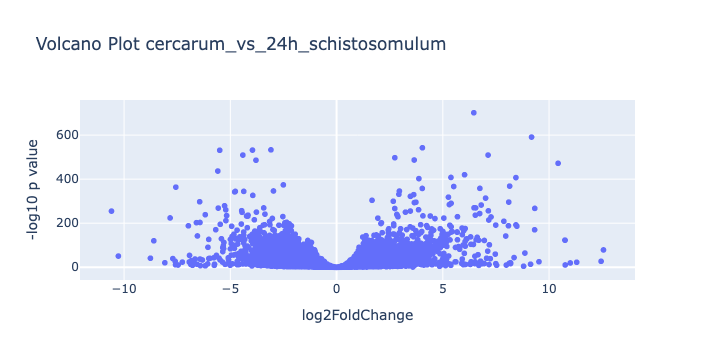

In [18]:
# Now, we can use our new columns to make the volcano plot
fig = px.scatter(
    res,
    x='log2FoldChange',
    y='-log10 p value',
    hover_data=['log2FoldChange', 'padj','gene'],
    title='Volcano Plot cercarum_vs_24h_schistosomulum'
)

# Show the plot
fig.show() # this takes a while to appear

# Visualisation - Clustermap (Extension)

<figure>
    <img src="https://scienceparkstudygroup.github.io/rna-seq-lesson/img/06-basic-heatmap.png" align="right" width="400">
</figure>

A common way to visualise gene expression is a [clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap). 

Clustermaps combine a heatmap, which you already used in Data Exploration (class 5, week 3 and others), with clustering. As shown in the figure on the right (taken from [this source](https://scienceparkstudygroup.github.io/rna-seq-lesson/06-differential-analysis/index.html#4-heatmap), gene expression values are represented on a color scale, and genes with a similar pattern of expression are grouped together.

To improve visualisation, gene expression values are transformed to logarithm before graphing them. Because some genes might have expression=0, and the log of 0 is undefined, often the `log1p` transformation is applied. This returns the logarithm of (1 + expression value). So, if the expression of a particular gene is 0, instead of returning an error (because log(0) = undefined), it will return 0 (because log(1+0)=0). 

Lets visualise our significantly regulated genes, which we have stored in the sigs dataframe, in a clustermap.

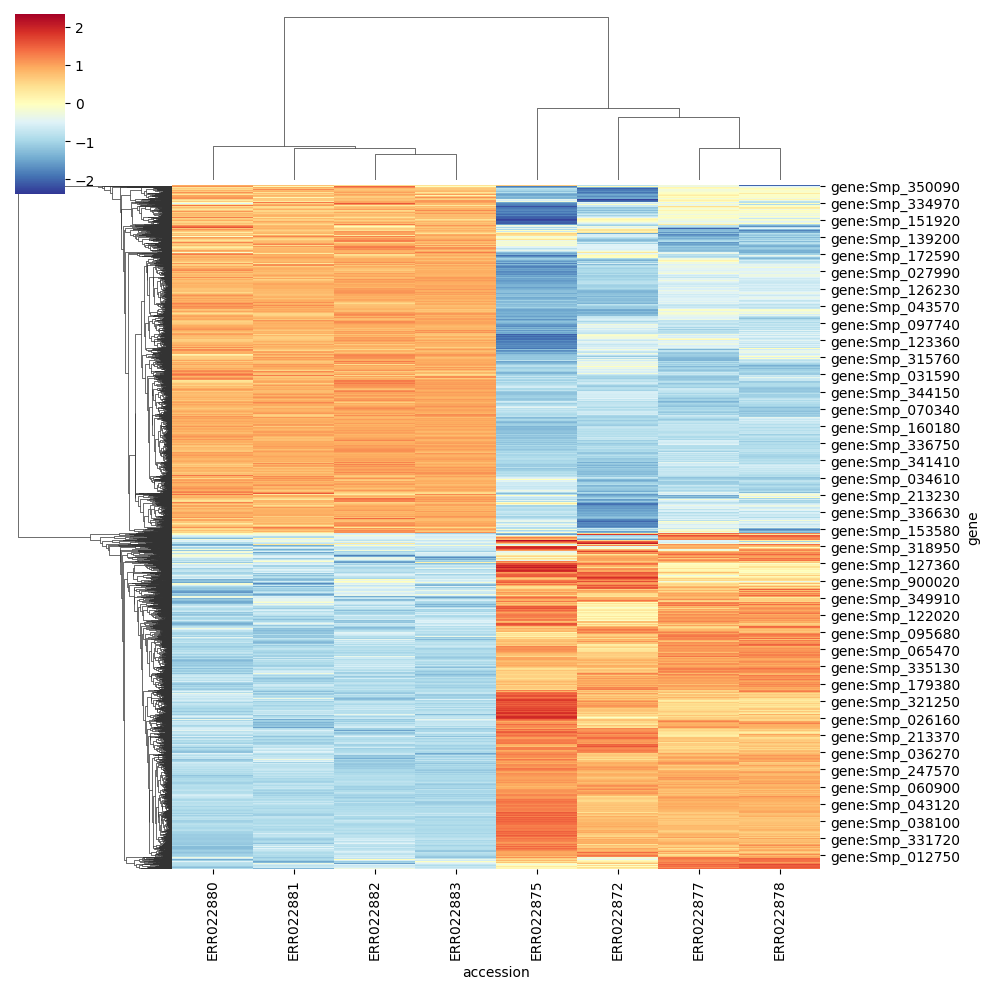

In [19]:
# perform the log transformation on the normalized counts stored in dds.layers['normed_counts']
# and save the result in a new layer called log1p
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

# from our dds, select only the genes that are significantly regulated (which we stored in the sigs dataset)
# and save the result as a new dds object called dds_sigs
dds_sigs = dds[:, sigs.index]

# create a dataframe called grapher that 
# - contains the log1p layer we just created, but transposed so that genes are rows and samples are columns
# - as index has the gene names from dds_sigs
# - as column names has the sample names from dds_sigs
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)
# make a clustermap of the data in the grapher dataframe
sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')

<div class="alert alert-block alert-warning">
    
Question:

10. Looking at the heatmap, would you say that:
    
    a. The majority of genes are upregulated in cercarium compared to 24h schistosomulum?
   
    b. The majority of downregulated in cercarium compared to 24h schistosomulum?
   
    c. Roughly half of the genes are upregulated in half are downregulated in cercarium compared to 24h schistosomulum?
    

<div class="alert alert-block alert-success">
    
Answers:

10. c